In [57]:
import math
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, StandardScaler # normalizer
import tensorflow as tf
from tensorflow import keras
import yfinance
from keras.models import Sequential
import datetime
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

In [58]:
current_date = datetime.date.today()
yesterday = current_date - datetime.timedelta(days=1)
df = yfinance.download('OLECTRA.NS', start='2016-01-01', end=current_date)
df

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2016-01-01,19.900000,20.799999,19.600000,20.100000,20.086821,117068
2016-01-04,19.299999,20.799999,18.750000,19.950001,19.936920,112623
2016-01-05,19.950001,20.299999,19.350000,19.950001,19.936920,40011
2016-01-06,20.700001,20.700001,19.299999,19.650000,19.637115,49745
2016-01-07,20.000000,21.450001,19.200001,20.049999,20.036852,115716
...,...,...,...,...,...,...
2023-05-16,674.000000,682.599976,662.099976,665.799988,665.799988,338376
2023-05-17,667.400024,667.400024,657.250000,662.900024,662.900024,238771
2023-05-18,666.500000,676.700012,658.650024,662.299988,662.299988,379800


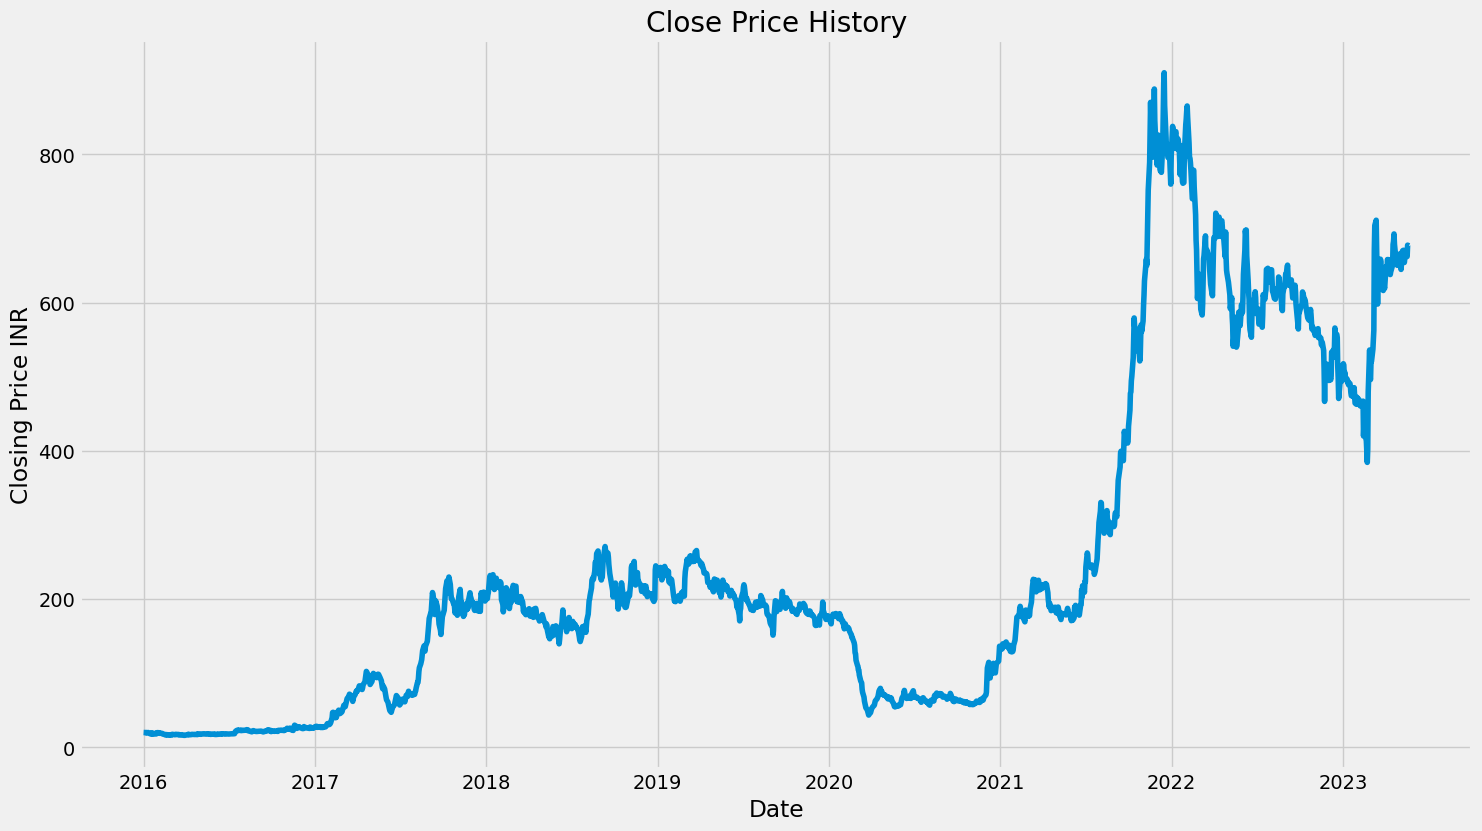

In [59]:
plt.figure(figsize=(16, 9))
plt.title('Close Price History')
plt.plot(df['Close'])
plt.xlabel('Date')
plt.ylabel('Closing Price INR')
plt.show()

In [60]:
data = df.filter(['Close'])
dataset = data.values
train_data_len = math.ceil(len(dataset) * 0.8)
train_data_len

1460

In [61]:
minmaxscaler = MinMaxScaler(feature_range=(0, 1))
standardscaler = StandardScaler()
minmax_scaled_data = minmaxscaler.fit_transform(dataset)
standard_scaled_data = standardscaler.fit_transform(dataset)

In [62]:
train_data = standard_scaled_data[:train_data_len, :]

train_data

array([[-1.01246084],
       [-1.0131352 ],
       [-1.0131352 ],
       ...,
       [ 2.50926379],
       [ 2.60187557],
       [ 2.42923997]])

In [63]:
X_train = []
y_train = []

for i in range(60, len(train_data)):
    X_train.append(train_data[i - 60 : i, 0])
    y_train.append(train_data[i, 0])

In [64]:
X_train, y_train = np.array(X_train), np.array(y_train)
X_train.shape, y_train.shape

((1400, 60), (1400,))

In [65]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_train.shape

(1400, 60, 1)

In [66]:
model = Sequential()

model.add(LSTM(50, return_sequences=True, input_shape = (X_train.shape[1], 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

In [67]:
model.compile(optimizer='adam', loss='mean_squared_error')

In [68]:
model.fit(X_train, y_train, batch_size=1, epochs=15)

Epoch 1/15
1400/1400 [==============================] - 42s 27ms/step - loss: 0.0158
Epoch 2/15
1400/1400 [==============================] - 37s 26ms/step - loss: 0.0065
Epoch 3/15
1400/1400 [==============================] - 37s 27ms/step - loss: 0.0047
Epoch 4/15
1400/1400 [==============================] - 37s 26ms/step - loss: 0.0052
Epoch 5/15
1400/1400 [==============================] - 37s 26ms/step - loss: 0.0036
Epoch 6/15
1400/1400 [==============================] - 37s 26ms/step - loss: 0.0044
Epoch 7/15
1400/1400 [==============================] - 38s 27ms/step - loss: 0.0026
Epoch 8/15
1400/1400 [==============================] - 36s 26ms/step - loss: 0.0028
Epoch 9/15
1400/1400 [==============================] - 36s 26ms/step - loss: 0.0021
Epoch 10/15
1400/1400 [==============================] - 36s 26ms/step - loss: 0.0029
Epoch 11/15
1400/1400 [==============================] - 36s 26ms/step - loss: 0.0026
Epoch 12/15
1400/1400 [==============================] - 36s 26

In [73]:
test_data = standard_scaled_data[train_data_len - 60:, :]
X_test = []
y_test = dataset[train_data_len:, :]
for i in range(60, len(test_data)):
    X_test.append(test_data[i-60:i, 0])

X_test = np.array(X_test)

X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

predictions = model.predict(X_test)
predictions = standardscaler.inverse_transform(predictions)

rmse = np.sqrt(np.mean(predictions - y_test) ** 2)
rmse

12/12 [==============================] - 0s 15ms/step


4.027293613978794

<ipython-input-74-2f9587c969d2>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


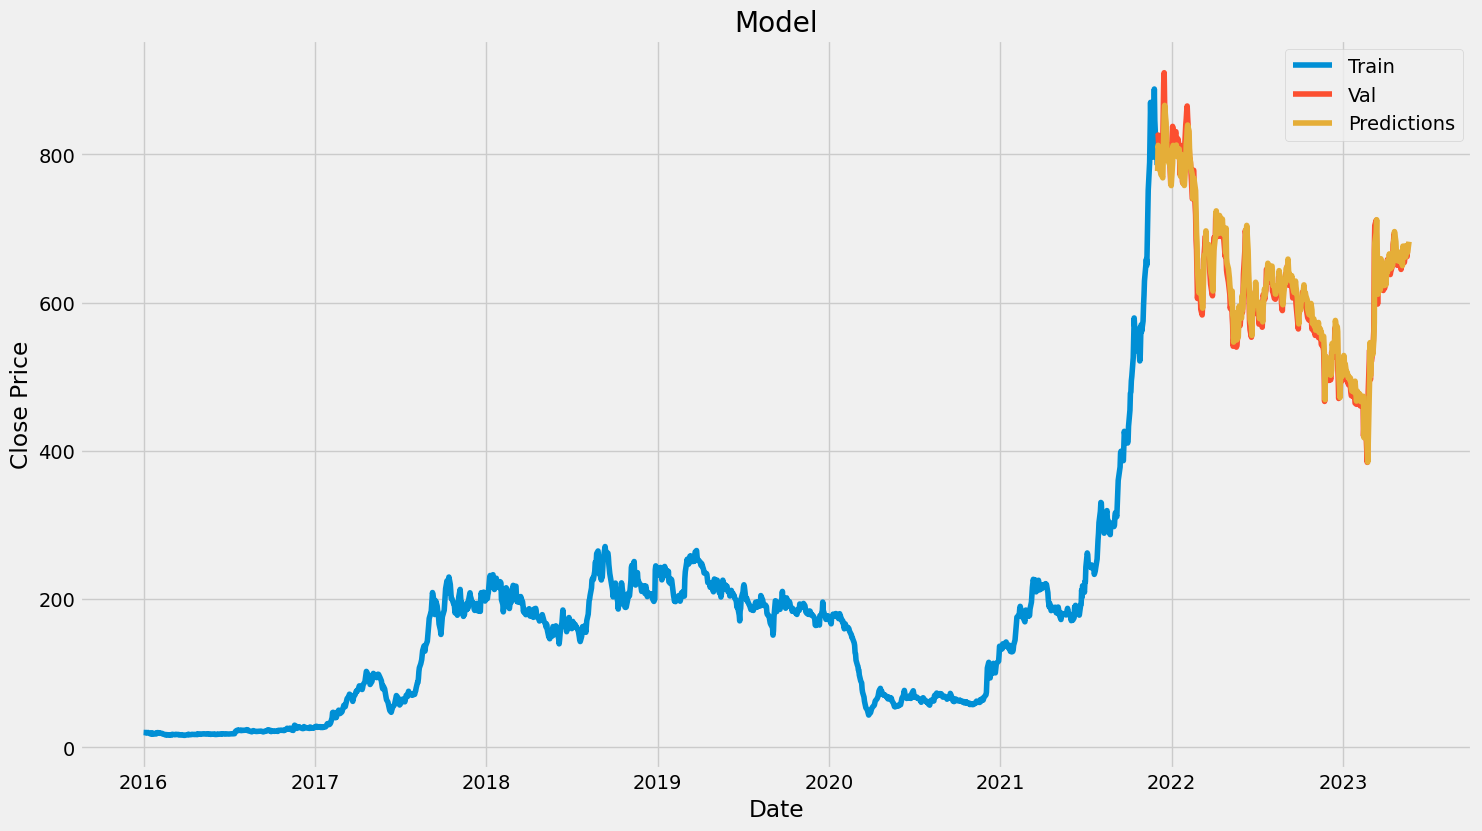

In [74]:
train = data[:train_data_len]
valid = data[train_data_len:]
valid['Predictions'] = predictions

plt.figure(figsize=(16, 9))
plt.title('Model')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'])
plt.show()

In [75]:
valid

,Close,Predictions
Date,,
2021-12-02,824.900024,777.687744
2021-12-03,826.250000,812.356079
2021-12-06,795.549988,803.426086
2021-12-07,780.549988,785.589417
2021-12-08,777.599976,777.052063
...,...,...
2023-05-16,665.799988,677.047119
2023-05-17,662.900024,668.841797
2023-05-18,662.299988,668.781006


In [76]:
quote = yfinance.download('OLECTRA.NS', start='2016-01-01', end=current_date)
new_df = quote.filter(['Close'])

last_60_days = new_df[-60:].values

last_60_days_scaled = standardscaler.transform(last_60_days)

X_test = []
X_test.append(last_60_days_scaled)

X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
pred_price = model.predict(X_test)

pred_price = standardscaler.inverse_transform(pred_price)
print(pred_price)

[*********************100%***********************]  1 of 1 completed
1/1 [==============================] - 0s 26ms/step
[[679.101]]
